# MOT lifetime
for making a vacuum pressure estimate

In [1]:
import scipy.io
import matplotlib.pyplot as plt
from numpy import *
from scipy.optimize import curve_fit

import sys
sys.path.append('../')
from simfuncs import *

In [2]:
def process_csv(fname, newline='', cols=True, skiprows=1):
    rows = []
    with open(fname, 'r', newline=newline) as f:
        reader = csv.reader(f, delimiter=',')

        while skiprows > 0:
            reader.__next__()
            skiprows -= 1
        
        for row in reader:
            try:
                rows.append([float(x) for x in row if x != ''])
            except ValueError:
                print(f"row is problematic: \n {row}")

    if cols:
        return array(rows).T
    
    return rows

## Cs 3D MOT loading curves

In [3]:
# fpath 
files = [
         'mot3d_loading_20211028.csv'
        ]

In [4]:
# sample the file contents, get time increment
fname = files[0]
newline=''
with open(fname, 'r', newline=newline) as f:
    reader = csv.reader(f, delimiter=',')
    for i,row in enumerate(reader):
        if i == 1:
            t_incr = float(row[-1])     
        if i < 10:
            print(row)

['time', 'with 2d mot', 'without 2d mot']
['0', '5279504.85', '5206514.8']
['263.1578947', '5372220.55', '5291268.75']
['526.3157895', '5453897.65', '5358872.4']
['789.4736842', '5508878.65', '5406378.3']
['1052.631579', '5553223.1', '5440405.45']
['1315.789474', '5583420.95', '5466560.45']
['1578.947368', '5619350.2', '5481570.7']
['1842.105263', '5618761.5', '5498492.65']
['2105.263158', '5623311.6', '5506846.2']


In [5]:
data = array([process_csv(f, newline='', cols=True, skiprows=1)
             for f in files])
# data.shape
tpts = data[0][0]/1e3 # convert to seconds
ypts_2d = data[0][1]
ypts_2d -= ypts_2d[0] 
ypts_no2d = data[0][2]
ypts_no2d -= ypts_no2d[0]

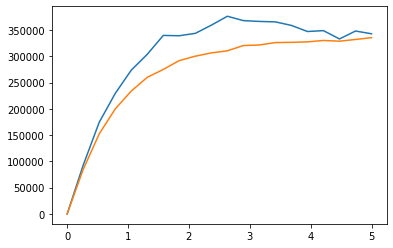

In [6]:
plt.plot(tpts,ypts_2d)
plt.plot(tpts,ypts_no2d)

In [17]:
gamma_b_per_P = 4.9e7 # cesium-non-cesium collisional losses [Torr^-1 s^-1]
beta = 4.013e7 # cesium-(hot)cesium collisional losses [Torr^-1 s^-1]

def loading_model(t,ns,tau):
    """
    MOT loading curve
    """    
    return ns*(1 - exp(-t/tau))

def gamma_model(tau,alpha_over_beta,gamma_b):
    """
    atom number as a function of tau to get alpha/beta and 
    the background-induced loss rate gamma_b
    """
    return alpha_over_beta*(1 - gamma_b*tau)                

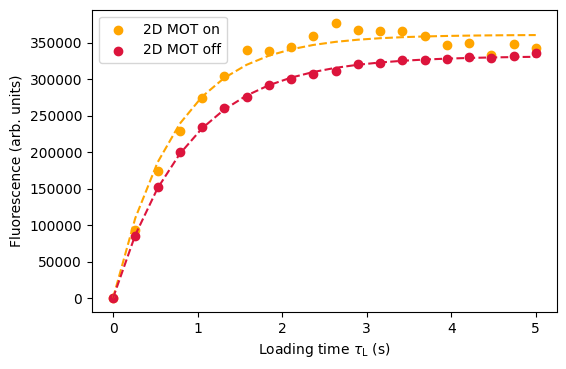

In [35]:
## fluorescence curves w/ and w/o loading

ns_pts = []
tau_pts = []
fig,ax = plt.subplots(dpi=100)

i=0
colors=['orange','crimson']
labels=['2D MOT on','2D MOT off']
for ypts in [ypts_2d,ypts_no2d]:
    
    popt, pcov = curve_fit(loading_model,tpts,ypts,
                               bounds=([100000,0],
                                       [500000,6]))
    
    ax.plot(tpts,loading_model(tpts,*popt),linestyle='--',color=colors[i])
    ax.scatter(tpts,ypts,color=colors[i],label=labels[i])
    
    ns,tau = popt
    ns_pts.append(ns)
    tau_pts.append(tau)
    i+=1
ax.set_xlabel(r'Loading time $\tau_{\rm L}$ (s)')
ax.set_ylabel('Fluorescence (arb. units)')
ax.legend()
# plt.savefig('CsMOT_loading_curves.pdf',bbox_inches='tight')

In [32]:
ns_pts, tau_pts

([360821.4570713522, 331722.1999584539],
 [0.7274553440926879, 0.8717261102633206])

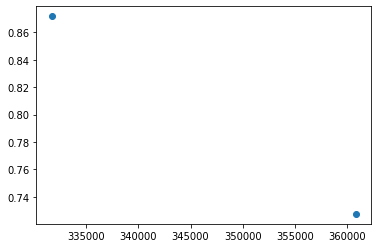

In [89]:
plt.scatter(ns_pts,tau_pts)

C:\Users\prest\.virtualenvs\rubidium-6bgZCrz4\lib\site-packages\scipy\optimize\_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


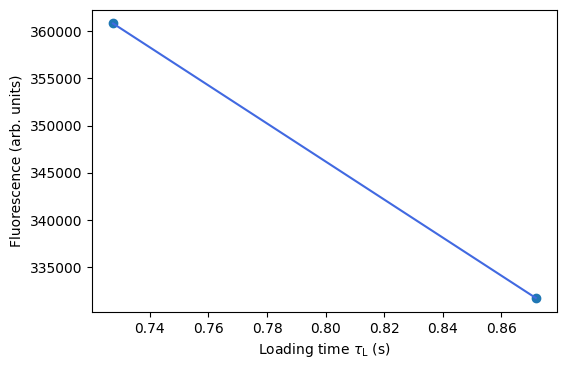

Cs background 1.8683053189315807e-08 Torr
non-Cs background 8.110170994844566e-09 Torr


In [33]:
# fit the ns,tau tuples to get alpha/beta and gamma_b
popt,pcov = curve_fit(gamma_model,tau_pts,ns_pts,
                               bounds=([0,0],
                                       [1e6,1e6]))
alpha_over_beta,gamma_b = popt

fig,ax = plt.subplots(dpi=100)
ax.scatter(tau_pts,ns_pts)
ax.plot(tau_pts, gamma_model(array(tau_pts), *popt),color='royalblue')

# cs pressure without the 2D MOT on
cs_pressure = ns_pts[1]/(alpha_over_beta*beta*tau_pts[1])
background_pressure = gamma_b/gamma_b_per_P

ax.set_xlabel(r'Loading time $\tau_{\rm L}$ (s)')
ax.set_ylabel(r'Fluorescence (arb. units)')
plt.savefig('CsMOT_Ns_tau_fit.pdf')
plt.show()

print(f"Cs background {cs_pressure} Torr")
print(f"non-Cs background {background_pressure} Torr")


In [34]:
popt

array([5.07548411e+05, 3.97398379e-01])

In [91]:
gamma_b

0.3973983835703132